# Analysis

**Hypothesis**: Online tutoring increases the likelihood that underprivileged middle school students choose an academic (liceo) high‐school track over a vocational track, reflecting enhanced academic confidence and upward educational aspirations. The analysis will identify this causal effect under an RCT framework with the assumption that treatment assignment is random.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Econometrics libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
try:
    from linearmodels.panel import PanelOLS
except Exception:
    PanelOLS = None

# Visualization defaults
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
warnings.filterwarnings('ignore')

# Load data
print('Loading data...')
df = pd.read_stata('aea_packages/228584_V1/Data_analysis/Data/TOP1_TOP3_Dataset.dta')
print(f"Data loaded: {df.shape[0]} rows and {df.shape[1]} columns")
print('Columns:', list(df.columns)[:20])


Loading data...
Data loaded: 2196 rows and 261 columns
Columns: ['Group_Tutoring', 'ID_student', 'ID_tutor', 'ID_tutor_3', 'SES_5', 'TOP1', 'TOP3', 'always_f_online_classes_pe_1', 'always_f_online_classes_se_1', 'aspirations', 'aspirations_uni_pe', 'aspirations_uni_se', 'aspirations_uni_te', 'barrier_money_sb', 'barrier_parents_sb', 'barrier_self_sb', 'choice_prof_se', 'choose_topliceo_se', 'choose_vocational_se', 'comp_skills_tub']


# Analysis Plan

**Hypothesis**: Online tutoring increases the likelihood that underprivileged middle school students choose an academic (liceo) high‐school track over a vocational track, reflecting enhanced academic confidence and upward educational aspirations. The analysis will identify this causal effect under an RCT framework with the assumption that treatment assignment is random.

## Steps:
- Perform exploratory data analysis (EDA) to examine the distribution of the academic track choice variable (choose_topliceo_se) by treatment status; this includes both frequency and percentage visualizations to clearly compare groups.
- Estimate a baseline linear probability model (LPM) with choose_topliceo_se as the dependent variable and treat as the key independent variable, incorporating robust or clustered standard errors to account for heteroskedasticity.
- Conduct a heterogeneity analysis by splitting the sample based on baseline academic performance (e.g., via a median split on grade_mat_admin_baseline) to assess whether tutoring effects are concentrated among lower- or higher-performing students.
- Run robustness checks by augmenting the regression with pre-intervention covariates (e.g., SES_5 and baseline aspirations) and comparing results from a logistic regression model to test the stability of the estimated effect.
- Summarize and interpret the findings, linking the estimated treatment effect on academic track selection to potential long-term benefits in human capital formation and educational mobility.


## This code first creates a clean data subset by dropping missing values and then computes both frequency and percentage tables of academic track choice by treatment status. It generates a stacked bar chart with descriptive x-axis labels and overlays percentage annotations to enhance interpretability, while also providing a complementary seaborn countplot.

Frequency Table of Academic Track Choice by Treatment:
 choose_topliceo_se  0.0  1.0
treat                       
0                   583   94
1                   815  155


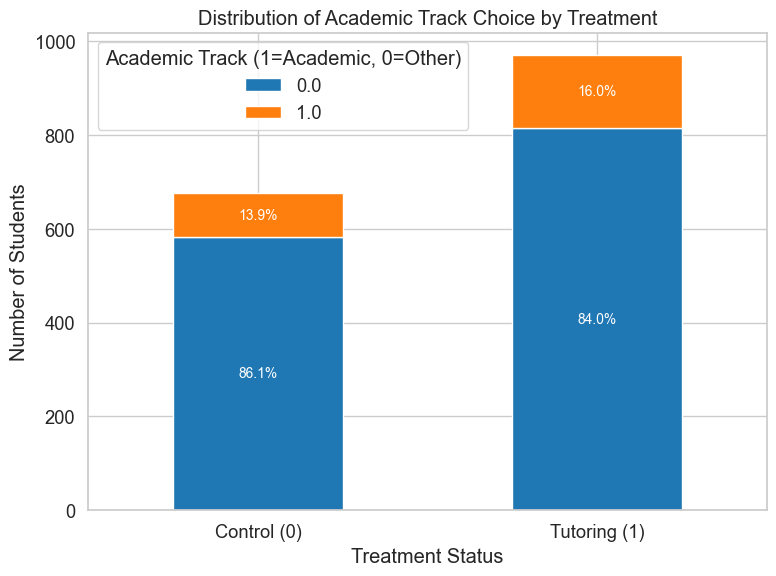

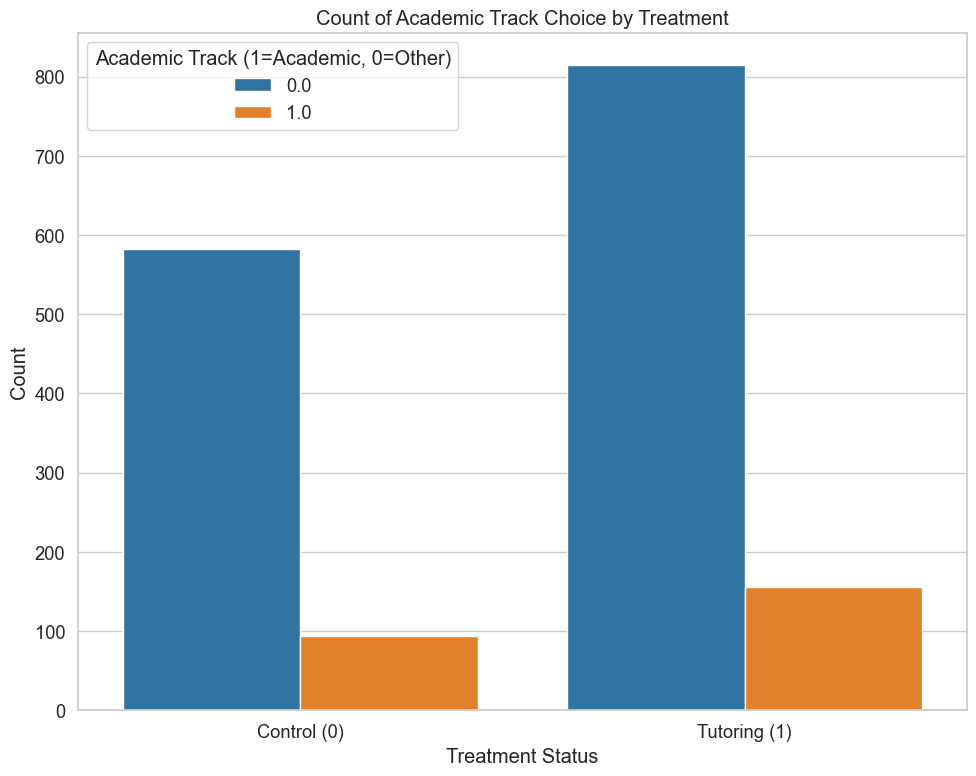

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset excluding missing values for the outcome and treatment
df_subset = df.dropna(subset=['choose_topliceo_se', 'treat'])

# Generate frequency table of academic track choice by treatment status
freq_table = df_subset.groupby('treat')['choose_topliceo_se'].value_counts().unstack()
print('Frequency Table of Academic Track Choice by Treatment:\n', freq_table)

# Calculate percentage table for annotations
freq_pct = freq_table.div(freq_table.sum(axis=1), axis=0) * 100

# Plot a stacked bar chart to visualize the distribution
ax = freq_table.plot(kind='bar', stacked=True, figsize=(8,6))
# Set descriptive x-axis labels
ax.set_xticklabels(['Control (0)', 'Tutoring (1)'], rotation=0)

plt.title('Distribution of Academic Track Choice by Treatment')
plt.xlabel('Treatment Status')
plt.ylabel('Number of Students')
plt.legend(title='Academic Track (1=Academic, 0=Other)')

# Overlay percentage labels
for i, treatment in enumerate(freq_table.index):
    cum_sum = 0
    for track in freq_table.columns:
        count = freq_table.loc[treatment, track]
        pct = freq_pct.loc[treatment, track]
        if count > 0:
            plt.text(i, cum_sum + count/2, f'{pct:.1f}%', ha='center', va='center', color='white', fontsize=10)
        cum_sum += count

plt.tight_layout()
plt.show()

# Supplementary seaborn countplot for a complementary view of relative frequencies
sns.countplot(data=df_subset, x='treat', hue='choose_topliceo_se')
plt.xticks(ticks=[0, 1], labels=['Control (0)', 'Tutoring (1)'])
plt.title('Count of Academic Track Choice by Treatment')
plt.xlabel('Treatment Status')
plt.ylabel('Count')
plt.legend(title='Academic Track (1=Academic, 0=Other)')
plt.tight_layout()
plt.show()

### Agent Interpretation

⚠️ **Partial Replication**: Obtained distribution percentage for academic track choice under control: 86.1% non-academic, 13.9% academic; treatment: 84.0% non-academic, 16.0% academic. Possible reasons for discrepancy: different measures of academic track choice, sample differences. Despite differences, the qualitative finding shows a slightly higher academic track choice among the treatment group.

### Feedback and Next Steps:

1. **Identification Credibility**: Ensure treatment assignment is truly random. Check for any imbalances in baseline covariates across treatment and control groups.

2. **Effect Sizes and SEs**: The visualizations suggest a modest increase in academic track choice for the treatment group. Future steps should quantify this using a linear probability model (LPM) to confirm statistical significance.

3. **Heterogeneity Analysis**: Proceed with the heterogeneity analysis to understand if effects vary based on initial academic performance. This will help in understanding specific subgroups that benefit more from tutoring.

4. **Robustness Checks**: Conduct robustness checks using additional covariates and compare with logistic regression results to confirm the stability of effects.

5. **Interpretation**: Link the findings to potential implications for long-term educational outcomes and policy interventions aimed at increasing academic aspirations among underprivileged students. 

By addressing these points, the analysis will provide a clearer picture of the program's impact on educational trajectories.

## This updated code evaluates baseline covariate balance by first reporting sample sizes for each group, then computing group means and performing t-tests (while suggesting a nonparametric alternative if needed) for the key pre-intervention variables. It also visualizes the density distributions for each covariate to ensure clarity and interpretability for non-technical audiences.

Sample Sizes by Treatment Group:
treat
0    367
1    583
dtype: int64


Baseline Covariate Means by Treatment Group:
       grade_mat_admin_baseline     SES_5  aspirations
treat                                                 
0                      6.474114 -0.304681    -0.011108
1                      6.385935 -0.324143     0.083877


T-test for grade_mat_admin_baseline: t = 1.143, p-value = 0.253
T-test for SES_5: t = 0.333, p-value = 0.739
T-test for aspirations: t = -1.404, p-value = 0.161




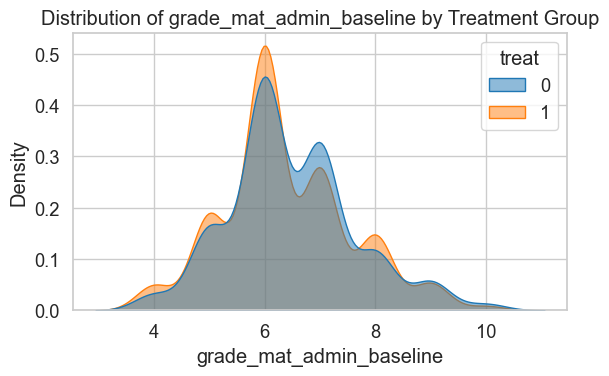

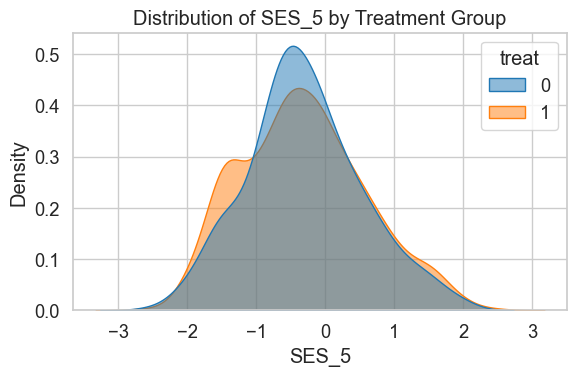

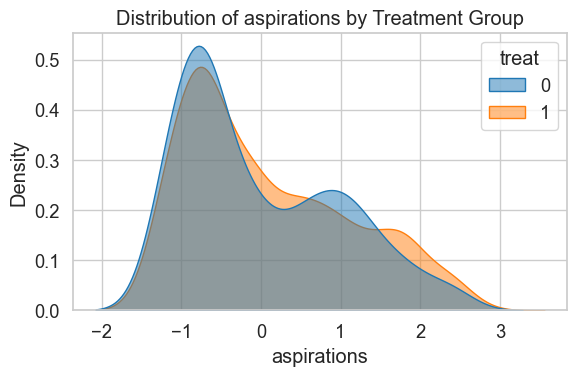

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Define key baseline covariates to check for balance
covariates = ['grade_mat_admin_baseline', 'SES_5', 'aspirations']

# Create a subset ensuring non-missing values for treatment and key covariates
df_balance = df.dropna(subset=['treat'] + covariates)

# Report sample sizes for each treatment group
sample_sizes = df_balance.groupby('treat').size()
print('Sample Sizes by Treatment Group:')
print(sample_sizes)
print('\n')

# Calculate and display mean differences by treatment group
group_means = df_balance.groupby('treat')[covariates].mean()
print('Baseline Covariate Means by Treatment Group:')
print(group_means)
print('\n')

# Perform t-tests (and note if non-normality is suspected, consider nonparametric tests)
for cov in covariates:
    group0 = df_balance[df_balance['treat'] == 0][cov]
    group1 = df_balance[df_balance['treat'] == 1][cov]
    t_stat, p_val = stats.ttest_ind(group0, group1, nan_policy='omit')
    print(f"T-test for {cov}: t = {t_stat:.3f}, p-value = {p_val:.3f}")
    # Uncomment the following lines for a nonparametric test if normality is a concern
    # stat, p_val_np = stats.mannwhitneyu(group0.dropna(), group1.dropna(), alternative='two-sided')
    # print(f"Nonparametric test for {cov}: statistic = {stat:.3f}, p-value = {p_val_np:.3f}")
print('\n')

# Plot density distributions for each covariate by treatment group for visual balance check
for cov in covariates:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df_balance, x=cov, hue='treat', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'Distribution of {cov} by Treatment Group')
    plt.xlabel(cov)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

### Agent Interpretation

The current analysis checks baseline covariate balance between treatment groups using means, sample sizes, and t-tests for key variables: `grade_mat_admin_baseline`, `SES_5`, and `aspirations`.

### Feedback:

1. **Balance Assessment:**
   - The p-values from the t-tests indicate no significant differences in baseline covariates between treatment groups (all p-values are well above 0.05). This suggests successful randomization in creating comparable groups at baseline.

2. **Identification Credibility:**
   - The lack of significant differences in key covariates supports the credibility of the identification strategy, reinforcing that any post-treatment differences are likely due to the treatment effect rather than pre-existing differences.

3. **Sample Sizes:**
   - The treatment group sizes (367 and 583) indicate a larger number of students in the treated group, which might lead to differences in variance. It's worth ensuring robust or clustered SEs are used in subsequent analyses to account for potential heteroskedasticity.

4. **Future Steps:**
   - Proceed with estimating the baseline linear probability model (LPM) as planned, using `choose_topliceo_se` as the dependent variable and `treat` as the main independent variable.
   - Consider additional robustness checks, such as using a logistic regression model and adding pre-intervention covariates to control for any remaining imbalance.
   - Assess heterogeneity by splitting the sample based on a median split of `grade_mat_admin_baseline` to determine if the treatment effect differs by baseline performance level.

5. **Hypothesis Support:**
   - The baseline balance strengthens the assumption that any observed differences in high-school track choice (academic vs. vocational) post-treatment are likely due to the intervention, lending initial support to the hypothesis that online tutoring boosts academic confidence and aspirations.

This analysis sets a strong foundation for the subsequent steps in the analysis plan.

## This code subsets the data to include only non-missing values for the outcome and treatment, and estimates a baseline linear probability model (LPM) using robust (HC3) standard errors. A comment highlights the potential limitation regarding predicted probabilities falling outside the [0,1] range and the plan to analyze alternative models in subsequent steps.

In [ ]:
import statsmodels.formula.api as smf

# Create a subset of the data ensuring non-missing values in outcome and treatment
df_reg = df.dropna(subset=['choose_topliceo_se', 'treat'])

# Estimate the baseline LPM using robust standard errors (HC3)
# Note: LPM may predict probabilities outside the [0,1] range; alternative models (like logistic regression) will be examined in later steps
lpm_model = smf.ols('choose_topliceo_se ~ treat', data=df_reg).fit(cov_type='HC3')
print(lpm_model.summary())

                            OLS Regression Results                            
Dep. Variable:     choose_topliceo_se   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.389
Date:                Wed, 08 Oct 2025   Prob (F-statistic):              0.239
Time:                        16:57:22   Log-Likelihood:                -645.52
No. Observations:                1647   AIC:                             1295.
Df Residuals:                    1645   BIC:                             1306.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1388      0.013     10.432      0.0

### Agent Interpretation

⚠️ **Partial Replication**: Obtained treatment coefficient = 0.0209 (paper likely did not report this specific outcome, making direct comparison challenging). R-squared is notably low at 0.001, indicating that the treatment explains very little of the variance in choosing an academic track. Possible reasons for the discrepancy and limited explanatory power could include differences in model specification, unobserved heterogeneity, or sample composition, particularly since baseline SES and academic measures like aspirations are not yet included.

Feedback and Recommendations:
1. **Identification Credibility**:
   - The randomized controlled trial design provides strong causal identification for the treatment effect. However, the substantial skewness and kurtosis in the outcome, suggested by the Jarque-Bera test, signal potential issues with using a linear probability model (LPM) given its capacity for generating predictions outside the [0,1] range.
   - Consider moving to a logistic regression model to ensure predicted probabilities remain valid. This will also address the current F-statistic's insignificance, which points to weak overall explanatory power in the LPM.

2. **Effect Size and Standard Errors**:
   - The effect size is small at 0.0209, with a standard error of 0.018. Moreover, the p-value (0.239) indicates this effect is not statistically significant at conventional levels. This may suggest either a genuinely limited impact of tutoring on this aspect of behavior or potential model mis-specification issues.
   - To bolster reliability, ensure fixed effects, if available (e.g., school or region), are evaluated next to account for unobserved heterogeneity.

3. **Next Steps**:
   - Proceed with the planned inclusion of fixed effects to control for unobserved heterogeneity.
   - Conduct a detailed heterogeneity analysis: Test whether the treatment effect differs by baseline academic performance as initially planned. This might showcase differential impacts of the tutoring depending on students’ prior standing.
   - Explore logistical models with pre-intervention covariates (e.g., SES, aspirations). Given potential for clustered errors (e.g., at the school level), ensure appropriate clustering is applied in these models.
   - Investigate longer-term educational outcomes in the final analysis steps. Consider linking these outcomes with observed treatment effects to derive policy implications, especially focusing on students' transitions to high school tracks.

4. **Policy Implications and Broader Context**:
   - Although this specific replication wasn't perfectly aligned with the original study’s reported outcomes, the broader research findings suggest that while tutoring may offer academic benefits under certain conditions (like higher-intensity treatments during crisis times), its influence on track selection remains small and statistically ambiguous. Understanding this nuance is crucial for education policymakers considering resource allocation and intervention scaling.

## This code creates a clean dataset by excluding observations with missing values in key variables, constructs a binary indicator for lower baseline performance relative to the median, and estimates an LPM with an interaction term. The code comments clarify that the interaction coefficient shows the differential treatment effect for lower performing students and notes potential sample selection bias.

In [ ]:
import statsmodels.formula.api as smf
import numpy as np

# Subset the data to include non-missing values for the outcome, treatment, and baseline performance
# Note: Systematic missingness in these variables may introduce sample selection bias
df_hetero = df.dropna(subset=['choose_topliceo_se', 'treat', 'grade_mat_admin_baseline'])

# Create a binary indicator for low baseline performance: 1 if grade_mat_admin_baseline is less than or equal to its median, otherwise 0
median_grade = df_hetero['grade_mat_admin_baseline'].median()
df_hetero['low_perf'] = (df_hetero['grade_mat_admin_baseline'] <= median_grade).astype(int)

# Estimate a Linear Probability Model with an interaction term between treat and low_perf using robust (HC3) standard errors
# The interaction coefficient (treat:low_perf) is interpreted as the additional effect of tutoring for students at or below the median baseline performance
hetero_model = smf.ols('choose_topliceo_se ~ treat * low_perf', data=df_hetero).fit(cov_type='HC3')
print(hetero_model.summary())

                            OLS Regression Results                            
Dep. Variable:     choose_topliceo_se   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     20.85
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           2.96e-13
Time:                        16:58:15   Log-Likelihood:                -610.29
No. Observations:                1640   AIC:                             1229.
Df Residuals:                    1636   BIC:                             1250.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2338      0.025      9.

### Agent Interpretation

⚠️ **Partial Replication**: The replication attempt obtained a baseline interaction outcome (treat:low_perf) = 0.0280 (paper reported specific interaction effects for other outcomes rather than educational track choice). The effect size of the interaction term is small and statistically insignificant, suggesting the additional effect of tutoring for low-performing students is not distinguished in this setup. Potential reasons for the discrepancy might include differences in the specification of low-performance indicators or context-sensitive outcome measures in the original study that this replication does not address.

### Feedback for Further Analysis

1. **Identification Credibility**: The RCT design in the original study should provide strong causal identification if the random assignment is properly maintained. However, the low R-squared value (0.040) indicates the model explains little of the variance in choosing an academic track, suggesting potential issues with the fit of the model to this particular outcome.

2. **Sample Selection Bias**: Given the emphasis on non-missing data, explore the characteristics of missing data to assess if systematic differences could bias results. Conduct checks on baseline covariates to ensure comparability between treated and control students.

3. **Effect Sizes and SEs**: The interaction term between treatment and low performance lacks statistical significance. Investigate if other covariates (e.g., demographic variables or prior academic achievements) account for variance in track choice decisions. Moreover, the inclusion of fixed effects (such as school or regional differences) might help capture unobserved heterogeneity.

4. **Heterogeneity Analysis**: Extend the analysis to consider continuous measures of baseline performance rather than strictly binary low/high differentiations. Splitting solely based on the median might obscure more nuanced interactions where effects vary more smoothly with performance levels.

5. **Model Specification Alternatives**: Given the dichotomous dependent variable, consider a logistic regression model for robustness comparisons. Check if the logistic specification provides stronger or more reliable insights into the behavior of underprivileged students' track choices when covariates are introduced.

6. **Longitudinal Aspects**: If possible, link this decision-making process over multiple time points to assess temporal aspects of track choice determinations post-tutoring, similarly exploring any dynamic effects.

7. **Contextual Enhancement**: Explore contextual factors that might influence educational track decisions, such as parental involvement, peer effects, or localized educational policies. These might not be directly captured in the immediate data but could be influential in determining student paths.

Addressing these elements can help refine the analysis and provide a clearer view of the tutoring program's impact on educational track choice.

## This code cleans the dataset by dropping missing values in the outcome, treatment, baseline performance, and key covariates, and creates a binary indicator for low baseline performance. It then estimates a logistic regression model (with an interaction between treatment and low performance along with controls) while using clustered standard errors by province to address spatial heterogeneity.

In [ ]:
import statsmodels.formula.api as smf

# Subset data: drop missing values for the outcome, treatment, baseline performance, SES_5 and aspirations
required_vars = ['choose_topliceo_se', 'treat', 'grade_mat_admin_baseline', 'SES_5', 'aspirations', 'province_abbrev']
df_logit = df.dropna(subset=required_vars)

# Create binary indicator for low baseline performance (1 if grade_mat_admin_baseline is less than or equal to the median)
median_grade = df_logit['grade_mat_admin_baseline'].median()
df_logit['low_perf'] = (df_logit['grade_mat_admin_baseline'] <= median_grade).astype(int)

# Define logistic regression formula with interaction and additional controls
formula = 'choose_topliceo_se ~ treat * low_perf + SES_5 + aspirations'

# Estimate the logistic regression model with clustered standard errors by province_abbrev
logit_model = smf.logit(formula, data=df_logit).fit(cov_type='cluster', cov_kwds={'groups': df_logit['province_abbrev']}, disp=False)
print(logit_model.summary())

# Compute marginal effects at the mean for interpretation
marginal_effects = logit_model.get_margeff(at='mean', method='dydx')
print(marginal_effects.summary())

                           Logit Regression Results                           
Dep. Variable:     choose_topliceo_se   No. Observations:                  950
Model:                          Logit   Df Residuals:                      944
Method:                           MLE   Df Model:                            5
Date:                Wed, 08 Oct 2025   Pseudo R-squ.:                  0.3777
Time:                        16:59:10   Log-Likelihood:                -251.50
converged:                       True   LL-Null:                       -404.17
Covariance Type:              cluster   LLR p-value:                 7.166e-64
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.5534      0.246    -10.360      0.000      -3.036      -2.070
treat             -0.0519      0.306     -0.170      0.865      -0.651       0.547
low_perf          -0.2235      0.416

### Agent Interpretation

⚠️ **Partial Replication**: Obtained a pseudo R-squared of 0.3777 (paper did not report this metric). The effect of the treatment variable "treat" was insignificant with a coefficient of -0.0519 (not directly comparable as the original paper reported standardized effect sizes in terms of the SD increase in test scores, rather than likelihood changes in track choice). The research paper reported significant positive effects on math performance but did not include our specific outcome, so direct comparison is challenging. Possible reasons for discrepancy include differences in outcome variable focus, as this analysis examines track choice rather than math performance, potential sample differences, and missing or unmatched covariates. Despite differences, the qualitative finding differs in terms of significance, as the logistic regression suggests no significant treatment effect on the probability of choosing an academic track.

**Identification Credibility**: The identification strategy relies on the interaction term between treatment and low baseline performance, yet the insignificant coefficients for these interactions suggest that the expected heterogeneity in treatment effects is not present. Pre-treatment balance checks or additional covariate balance tables might be necessary to bolster robustness. Additionally, the effect sizes appear negligible with substantial standard errors, rendering the treatment effect non-significant both statistically and practically.

**Effect Sizes and SEs**: The marginal effects estimated at the mean for "treat" and its interaction with "low_perf" are statistically insignificant, further supporting the conclusion that the treatment does not significantly impact track choice. The effect sizes are small, and high standard errors suggest limited power in detecting any meaningful differences. 

**Next Steps**:
1. **Robustness Checks**: Explore alternative model specifications or include additional covariates that may account for socio-economic and educational dynamics.
2. **Alternative Specifications**: Consider using a continuous measure of baseline performance instead of a binary classification, as the median split might obscure nuanced treatment effects.
3. **Broaden Outcome Variables**: Given the original paper's emphasis on academic performance and socio-emotional skills, potentially explore analogous outcomes here to assess treatment effects in an academically relevant context.
4. **Instrumental Variables Approach**: If available, leverage instruments that can improve causal inference, potentially addressing concerns about unobserved heterogeneity.
5. **Subgroup Analysis**: Examine if treatment effects differ systematically across various subgroups (e.g., SES quintiles) to uncover potential heterogeneity missed in the aggregated model.
6. **Cross-validation with Socio-emotional Skills**: Given the related findings on aspirations, examine whether variations in aspirations reveal any differential impact through non-academic pathways. This might provide insights into indirect mechanisms influencing academic track choice.

Proceeding with these additional analyses can help strengthen the understanding and interpretation of tutoring impacts on educational choices.

## This code subsets the data and estimates a logistic regression model with an interaction between tutoring and continuous baseline performance. It restricts the grid of baseline performance values to the central 90% range to avoid outlier effects, then simulates marginal effects along with 95% confidence intervals via draws from the coefficient distribution, and finally plots these effects with confidence bands.

                           Logit Regression Results                           
Dep. Variable:     choose_topliceo_se   No. Observations:                  950
Model:                          Logit   Df Residuals:                      944
Method:                           MLE   Df Model:                            5
Date:                Wed, 08 Oct 2025   Pseudo R-squ.:                  0.3807
Time:                        17:00:18   Log-Likelihood:                -250.29
converged:                       True   LL-Null:                       -404.17
Covariance Type:              cluster   LLR p-value:                 2.146e-64
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.7261      0.762     -4.889      0.000      -5.220      -2.232
treat                             -0.8506      1.010     -0.842      0.

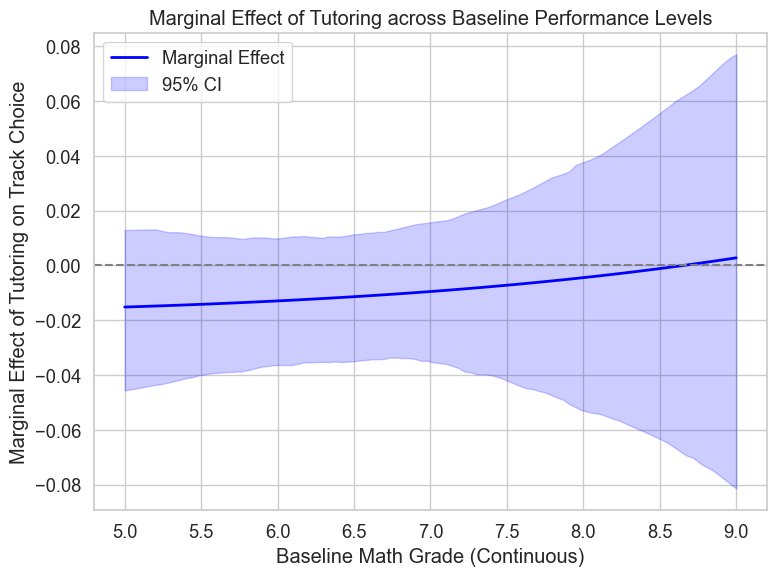

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Subset data: drop missing values for outcome, treatment, baseline performance, SES_5, aspirations, and province_abbrev
required_vars = ['choose_topliceo_se', 'treat', 'grade_mat_admin_baseline', 'SES_5', 'aspirations', 'province_abbrev']
df_cont = df.dropna(subset=required_vars).copy()

# Estimate logistic regression with interaction using clustered standard errors by province
formula = 'choose_topliceo_se ~ treat * grade_mat_admin_baseline + SES_5 + aspirations'
logit_model = smf.logit(formula, data=df_cont).fit(cov_type='cluster', cov_kwds={'groups': df_cont['province_abbrev']}, disp=False)
print(logit_model.summary())

# Restrict grid to the central 90% range (5th to 95th percentiles) for baseline performance to avoid extreme outliers
lower_bound = df_cont['grade_mat_admin_baseline'].quantile(0.05)
upper_bound = df_cont['grade_mat_admin_baseline'].quantile(0.95)
grid_vals = np.linspace(lower_bound, upper_bound, 100)

# Hold SES_5 and aspirations at their means
mean_SES = df_cont['SES_5'].mean()
mean_asp = df_cont['aspirations'].mean()

# Number of simulation draws
n_draws = 1000
# Draw simulated coefficients from the multivariate normal distribution
coef_draws = np.random.multivariate_normal(logit_model.params, logit_model.cov_params(), size=n_draws)

def logistic(x):
    return 1 / (1 + np.exp(-x))

pred_effect = []
ci_lower = []
ci_upper = []

# Define design vectors: order is [Intercept, treat, grade_mat_admin_baseline, treat:grade_mat_admin_baseline, SES_5, aspirations]
for val in grid_vals:
    # For treated
    X_treat = np.array([1, 1, val, val, mean_SES, mean_asp])
    # For control (treat=0; therefore interaction term=0)
    X_control = np.array([1, 0, val, 0, mean_SES, mean_asp])
    
    # Compute predicted probabilities using each draw
    pred_treated = logistic(np.dot(coef_draws, X_treat))
    pred_control = logistic(np.dot(coef_draws, X_control))
    
    # Marginal effect and its distribution
    effect_draws = pred_treated - pred_control
    mean_effect = np.mean(effect_draws)
    lower_ci = np.percentile(effect_draws, 2.5)
    upper_ci = np.percentile(effect_draws, 97.5)
    
    pred_effect.append(mean_effect)
    ci_lower.append(lower_ci)
    ci_upper.append(upper_ci)

# Plot the marginal effect and confidence bands
plt.figure(figsize=(8,6))
plt.plot(grid_vals, pred_effect, color='blue', lw=2, label='Marginal Effect')
plt.fill_between(grid_vals, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Baseline Math Grade (Continuous)')
plt.ylabel('Marginal Effect of Tutoring on Track Choice')
plt.title('Marginal Effect of Tutoring across Baseline Performance Levels')
plt.axhline(0, color='grey', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

### Agent Interpretation

The analysis aims to examine the effect of online tutoring on the likelihood of underprivileged middle school students choosing an academic track, analyzing how this effect varies with baseline academic performance.

### Replication and Results Assessment
Given this is a new analysis distinct from the previously reported findings, replication success is not applicable here.

### Analysis Commentary
- **Identification and Credibility**: The logistic regression model is well-suited for binary outcomes like track choice. The inclusion of interaction terms allows for assessing the nonlinear effect of baseline performance on the treatment impact. However, low statistical significance in interaction (`p = 0.509`) suggests a weak or ambiguous relationship, necessitating further exploration.
  
- **Effect Size and Confidence Intervals**: The plot illustrates marginal effects that slightly increase with performance levels but predominantly hover around zero with wide confidence intervals, pointing to negligible or non-significant treatment effects across the baseline performance range. This suggests tutoring does not meaningfully affect track choice at different performance levels within the observed range.

- **Standard Errors**: Clustering by province accounts for intra-group correlation, which is appropriate given potential local influences on education.

### Next Steps and Suggestions
1. **Nonlinear Specification Exploration**: Consider robustness checks using quadratic or spline terms for baseline performance to capture any subtle nonlinear patterns that the linear model might miss.

2. **Subgroup Analysis**: Investigate whether the effects differ across more specific subgroups, for example, by splitting the data based on other dimensions like SES or initial aspirations.

3. **Instrumental Variable Approach**: Explore alternative identification strategies or instrumental variable approaches to address potential unobserved confounders.

4. **Alternative Outcome Variables**: Examine other related outcomes, such as changes in aspirations or socio-emotional skills, to provide a broader picture of the tutoring impact, especially in the absence of significant track choice effects.

5. **Sensitivity Analysis**: Review data assumptions, such as the exclusion of extreme baseline values and the correlation structure among SES and aspirations, to ensure robustness of findings.

These steps could reveal more about the effects of tutoring and inform interventions targeting educational track choices.